In [187]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import date, datetime, timedelta, timezone
%matplotlib inline

#set default plotting styles
sns.set(rc={'figure.figsize':(15, 6)})
sns.set_style("dark")
fig_dims = (15, 6)

In [188]:
print(os.getcwd())
sales_train_validation = pd.read_csv("./datasets/sales_train_validation.csv")
sales_train_validation.head()

/Users/christopherglenn/Dev/m5-forecasting-accuracy


,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4


In [189]:
master = sales_train_validation.melt(id_vars=['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], var_name='d')

In [190]:
calendar = pd.read_csv("./datasets/calendar.csv")
temp = calendar[['date', 'd']]
temp
#calendar.set_index('date', inplace=True)
#temp = pd.DataFrame(calendar['d'])

,date,d
0,2011-01-29,d_1
1,2011-01-30,d_2
2,2011-01-31,d_3
3,2011-02-01,d_4
4,2011-02-02,d_5
...,...,...
1964,2016-06-15,d_1965
1965,2016-06-16,d_1966
1966,2016-06-17,d_1967
1967,2016-06-18,d_1968


In [191]:
master = pd.merge(master, temp, on='d', how='inner')

In [192]:
master['date'] = pd.to_datetime(master['date'])
master = master.rename(columns={'value': 'unit_sales'})
master.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,unit_sales,date
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29


In [193]:
id_sales = master.groupby(['date', 'id'])['unit_sales'].agg('sum')
id_sales

date        id                             
2011-01-29  FOODS_1_001_CA_1_validation        3
            FOODS_1_001_CA_2_validation        2
            FOODS_1_001_CA_3_validation        1
            FOODS_1_001_CA_4_validation        0
            FOODS_1_001_TX_1_validation        0
                                              ..
2016-04-24  HOUSEHOLD_2_516_TX_2_validation    0
            HOUSEHOLD_2_516_TX_3_validation    0
            HOUSEHOLD_2_516_WI_1_validation    0
            HOUSEHOLD_2_516_WI_2_validation    0
            HOUSEHOLD_2_516_WI_3_validation    0
Name: unit_sales, Length: 58327370, dtype: int64

In [194]:
store_sales = master.groupby(['date', 'store_id'], as_index=False)['unit_sales'].agg('sum')
store_sales = pd.DataFrame(store_sales)
store_sales['date'] = pd.to_datetime(store_sales['date'])
store_sales

,date,store_id,unit_sales
0,2011-01-29,CA_1,4337
1,2011-01-29,CA_2,3494
2,2011-01-29,CA_3,4739
3,2011-01-29,CA_4,1625
4,2011-01-29,TX_1,2556
...,...,...,...
19125,2016-04-24,TX_2,4292
19126,2016-04-24,TX_3,3957
19127,2016-04-24,WI_1,4874
19128,2016-04-24,WI_2,5127


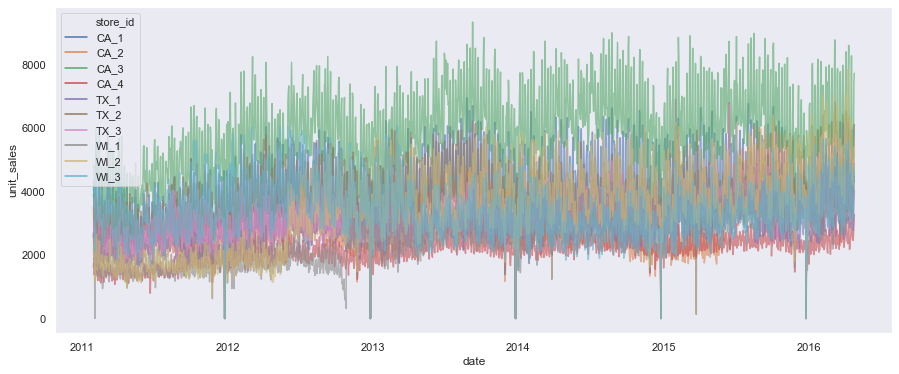

In [195]:
fig, ax = plt.subplots(figsize=fig_dims)
sns.lineplot(data=store_sales, 
             x='date', 
             y='unit_sales', 
             hue='store_id', 
             ax=ax, 
             alpha=0.6)
plt.show()

In [196]:
df2 = store_sales
df2 = df2.set_index('date')
# fig, ax = plt.subplots(figsize=fig_dims)
# sns.relplot(x="date", 
#             y="unit_sales",
#             hue="store_id", 
#             row="store_id",
#             facet_kws=dict(sharex=True),
#             kind="reg", 
#             legend="full", 
#             data=store_sales)
# sns.lmplot(x='date',
#            y='unit_sales',
#            hue='store_id', 
#            data=store_sales)
#sns.regplot(x="date", y="unit_sales", data=store_sales)
#sns.lmplot(x="date", y="unit_sales", hue="store_id", data=store_sales)

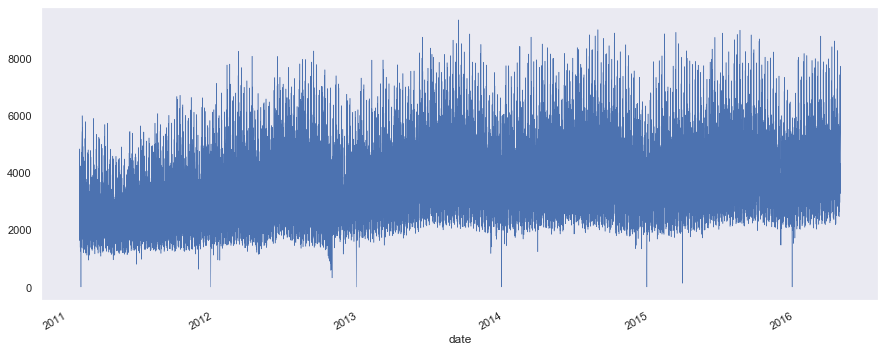

In [197]:
df2.loc[:, 'unit_sales'].plot(linewidth=0.5)
plt.show()

TypeError: unsupported operand type(s) for *: 'Timestamp' and 'float'

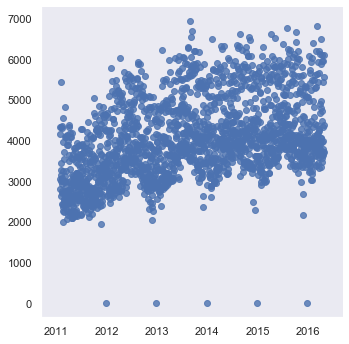

In [198]:
sns.lmplot(data=store_sales, 
             x='date', 
             y='unit_sales', 
             hue='store_id')